In [1]:
from nilearn._utils import check_niimg
from nilearn.input_data import NiftiLabelsMasker
import nibabel as nib
import numpy as np
import pandas as pd
from glob import glob
from nilearn.datasets import fetch_atlas_schaefer_2018

subjects = pd.read_csv('../FDG_BASELINE_HEALTHY_4_15_2021.csv')
subject_list = subjects['Subject'].tolist()
data_path = '/home/doeringe/Dokumente/brain age/4_SUVR/'
output_csv = '../data/parcels_FDG_tpm_ADNI.csv'
atlas = fetch_atlas_schaefer_2018(n_rois=200, yeo_networks = 17)

image_list = []
subj_succ = []
subj_miss = []
subj_year = []
subj_month = []
subj_age = []

# create list of regional data and subject IDs
for sub in subject_list:
    
    foi = glob(data_path + "SUV*" + sub + "*.nii")
    y = []
    
    # if there are several scans, only extract regional values for the first
    for n in range(len(foi)):
        y.append(int(foi[n][95:99]))
    base_ind_ = y.index(np.min(y))
    
    if foi and (sub not in subj_succ):
        this_image = nib.load(foi[base_ind_])
        niimg = check_niimg(this_image, atleast_4d=True)
        masker = NiftiLabelsMasker(labels_img=atlas.maps,
                                   standardize=False,
                                   memory='nilearn_cache',
                                   resampling_target='data')
        parcelled = masker.fit_transform(niimg)
        image_list.append(parcelled)
        subj_succ.append(sub)
        subj_year.append(foi[base_ind_][95:99])
        subj_month.append(foi[base_ind_][99:101])
        subj_age.append(np.min(subjects['Age'][subjects['Subject']==sub]))
        
    
features = np.array(image_list)
x, y, z = features.shape
features = features.reshape(x, z)
df = pd.DataFrame(features, columns=atlas.labels)

# combine information on subjects, age and regional data
subs = {'Subject' : subj_succ,
       'Age' : subj_age,
       'Year' : subj_year,
       'Month' : subj_month}
subs_pd = pd.DataFrame(subs)
df_new = pd.concat([subs_pd, df], axis=1)
df_new.to_csv(output_csv, index=False)


/opt/anaconda/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/parcels_FDG_tpm_ADNI.csv')

df['Agebins'] = df['Age'].values // 7
df['Agebins'] = df['Agebins'].astype(int)

col = [x for x in df.columns if '_' in x]

X = df[col].values

y_pseudo = df['Agebins']
y = df['Age']

x_train, x_test,  y_train, y_test, id_train, id_test = train_test_split(
    X, y, df['Subject'], test_size=.2, random_state=42,
    stratify=y_pseudo)

df['train'] = ["T" if x in id_train.values else "F" for x in df[
               'Subject']]

df.to_csv('../data/test_train_FDG_tpm_ADNI.csv')

<ipython-input-10-91593890f012>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Age'] = np.around(df_train['Age'].astype(int))


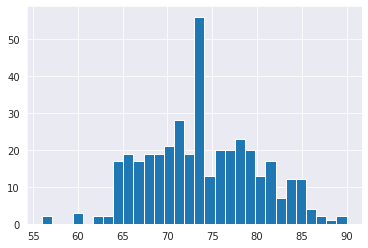

In [10]:
# In[1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
#pip install https://github.com/JamesRitchie/scikit-rvm/archive/master.zip
from skrvm import RVR
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from julearn import run_cross_validation
from julearn.utils import configure_logging
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn import plotting
from nilearn import image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.inspection import permutation_importance
sys.path.append("../lib")
from create_splits import stratified_splits

# configure_logging(level='INFO')
# TODO: do with FDG template
# in case seaborn conflicts with autocomplete

df_train = df[df['train'] == "T"]
col = [x for x in df_train.columns if '_' in x]

# round to no decimal place
df_train['Age'] = np.around(df_train['Age'].astype(int))
df_train = df_train.reset_index(drop=True)

#col = [x for x in df_train.columns if 'H_' in x]
plt.hist(y, bins=30)

rand_seed = 42
num_bins = 5
rvr = RVR()
models = [rvr, 'svm']
model_names = ['rvr', 'svm']
splits = 5

model_results = []
scores_results = []
res = {}
res['model'] = []
res['iter'] = []
res['pred'] = []
res['ind'] = []
# res = pd.Series(index=df_train.index)
for i, model in enumerate(models):
    cv = StratifiedKFold(n_splits=splits).split(df_train[col],
                                                df_train['Agebins'])
    cv = list(cv)
    scores, final_model = run_cross_validation(X=col, y='Age',
                                         #preprocess_X='scaler_robust',
                                         problem_type='regression',
                                         data=df_train,
                                         model=model, cv=cv,
                                         return_estimator='all',
                                         seed=rand_seed,
                                         scoring=[
                                            'r2', 'neg_mean_absolute_error'])
    model_results.append(final_model)
    scores_results.append(scores)
    for iter in range(splits):
        pred = scores.estimator[iter].predict(df_train.iloc[cv[iter][1]][col])
        res['pred'].append(pred)
        res['iter'].append(iter)
        res['model'].append(str(model))
        res['ind'].append(cv[iter][1])


# In[4]:


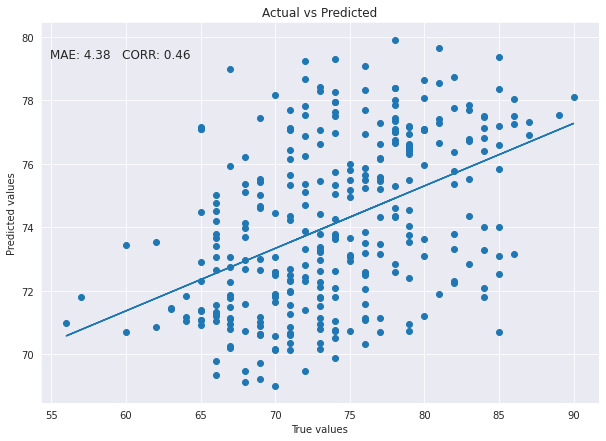

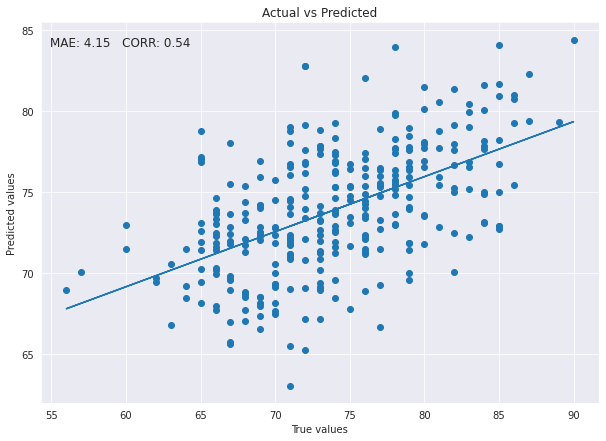

In [21]:
df_res = pd.DataFrame(res)
age_pred = {}
age_pred['subj'] = []
age_pred['pred'] = []
age_pred['real'] = []
age_pred['model'] = []
for i, fold in enumerate(df_res['ind']):
    for ind, sample in enumerate(fold):
        age_pred['real'].append(df_train.iloc[sample]['Age'])
        age_pred['pred'].append(df_res['pred'].iloc[i][ind])
        age_pred['subj'].append(df_train.iloc[sample]['Subject'])
        age_pred['model'].append(df_res.iloc[i]['model'])

df_ages = pd.DataFrame(age_pred)

y_true = df_ages[df_ages['model'] == 'svm']['real']
y_pred = df_ages[df_ages['model'] == 'svm']['pred']

mae = format(mean_absolute_error(y_true, y_pred), '.2f')
corr = format(np.corrcoef(y_pred, y_true)[1, 0], '.2f')

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set_style("darkgrid")
plt.scatter(y_true, y_pred)
m, b = np.polyfit(y_true, y_pred, 1)
plt.plot(y_true, m*y_true + b)
# ax = sns.regplot(x=y_true, y=y_pred)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
text = 'MAE: ' + str(mae) + '   CORR: ' + str(corr)
ax.set(xlabel='True values', ylabel='Predicted values')
plt.title('Actual vs Predicted')
plt.text(xmin + 10, ymax - 0.01 * ymax, text, verticalalignment='top',
         horizontalalignment='right', fontsize=12)
plt.savefig("train_performance_rvm_FDG.jpg")
plt.show()


y_true = df_ages[df_ages['model'] == 'RVR()']['real']
y_pred = df_ages[df_ages['model'] == 'RVR()']['pred']

mae = format(mean_absolute_error(y_true, y_pred), '.2f')
corr = format(np.corrcoef(y_pred, y_true)[1, 0], '.2f')

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set_style("darkgrid")
plt.scatter(y_true, y_pred)
m, b = np.polyfit(y_true, y_pred, 1)
plt.plot(y_true, m*y_true + b)
# ax = sns.regplot(x=y_true, y=y_pred)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
text = 'MAE: ' + str(mae) + '   CORR: ' + str(corr)
ax.set(xlabel='True values', ylabel='Predicted values')
plt.title('Actual vs Predicted')
plt.text(xmin + 10, ymax - 0.01 * ymax, text, verticalalignment='top',
         horizontalalignment='right', fontsize=12)
plt.savefig("train_performance_svm_FDG.jpg")
plt.show()

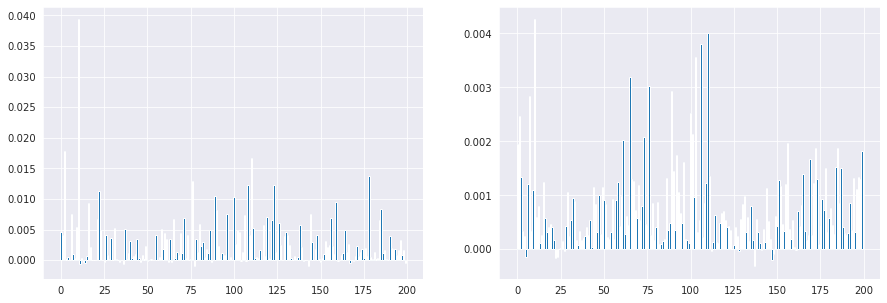

In [12]:
rvr.fit(X, y)
rvr_feature_importance = permutation_importance(model_results[0]['rvr'], X, y,
                                                scoring="r2")
svm = SVR().fit(X, y)
svr_feature_importance = permutation_importance(svm, X, y, scoring="r2")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(range(X.shape[1]), rvr_feature_importance.importances_mean)
ax[1].bar(range(X.shape[1]), svr_feature_importance.importances_mean)
plt.show()

In [13]:
schaefer = fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=17)
atlas = image.load_img(schaefer.maps)
atlas_matrix = image.get_data(atlas)

# create statistical map where each voxel value coresponds to permutation importance
rvr_imp = rvr_feature_importance.importances_mean
atlas_matrix_stat = atlas_matrix.copy()

for x in range(201):
    if x == 0:
        pass
    else:
        atlas_matrix_stat[atlas_matrix_stat == x] = rvr_imp[x-1]
atlas_rvr = image.new_img_like(atlas, atlas_matrix_stat)

svr_imp = svr_feature_importance.importances_mean
atlas_matrix_stat_svr = atlas_matrix.copy()

for x in range(201):
    if x == 0:
        pass
    else:
        atlas_matrix_stat_svr[atlas_matrix_stat_svr == x] = svr_imp[x-1]
atlas_svr = image.new_img_like(atlas, atlas_matrix_stat_svr)



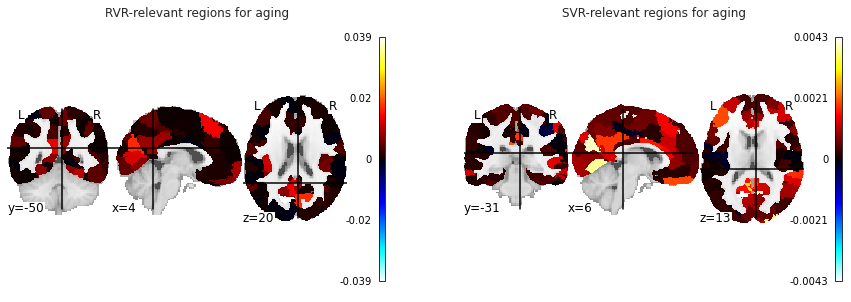

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plotting.plot_stat_map(atlas_rvr, axes=ax[0])
ax[0].set_title("RVR-relevant regions for aging")
plotting.plot_stat_map(atlas_svr, axes=ax[1])
ax[1].set_title("SVR-relevant regions for aging")
plt.savefig("Permutation_importance_FDG.jpg")
plt.show()

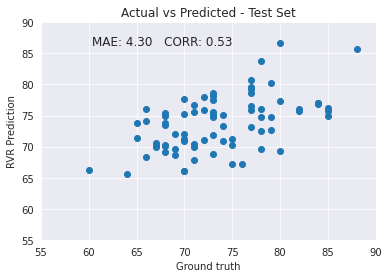

In [24]:
df_test = df[df['train'] == "F"]
col = [x for x in df_train.columns if '_' in x]

X_test = df_test[col].values
y_true = df_test['Age'].values

# In[26]:


y_pred = model_results[0]['rvr'].predict(X_test)

mae = format(mean_absolute_error(y_true, y_pred), '.2f')
corr = format(np.corrcoef(y_pred, y_true)[1, 0], '.2f')

plt.scatter(y_true, y_pred)
plt.xlabel("Ground truth")
plt.ylabel("RVR Prediction")
text = 'MAE: ' + str(mae) + '   CORR: ' + str(corr)
plt.title('Actual vs Predicted - Test Set')
plt.text(75, 88, text, verticalalignment='top',
         horizontalalignment='right', fontsize=12)
plt.xlim(55,90)
plt.ylim(55,90)
plt.savefig("train_performance_rvm.jpg")
plt.show()